In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import os

In [16]:
dataset_path = 'C:\\Users\\HP\\SenMangoFruitDDS_bgremoved'

In [17]:
IMAGE_WIDTH, IMAGE_HEIGHT = 150, 150
BATCH_SIZE = 16
EPOCHS = 100

In [18]:
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.15
)

# Generator untuk training dan validasi
train_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),  
    batch_size=BATCH_SIZE,
    class_mode='categorical',  
    subset='training'  
)

validation_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

Found 4123 images belonging to 5 classes.
Found 725 images belonging to 5 classes.


In [19]:
# Mendapatkan jumlah kelas dari direktori dataset
class_names = sorted([d.name for d in os.scandir(dataset_path) if d.is_dir()])
class_dict = {name: index for index, name in enumerate(class_names)}
num_classes = len(class_names)

In [20]:
# Membuat tabel pencarian dari string label ke integer
table = tf.lookup.StaticHashTable(
    initializer=tf.lookup.KeyValueTensorInitializer(
        keys=tf.constant(class_names),
        values=tf.constant(list(range(len(class_names)))),
    ),
    default_value=tf.constant(-1),
    name="class_to_index"
)

def parse_image(filename):
    parts = tf.strings.split(filename, os.path.sep)
    label_str = parts[-2]
    label = table.lookup(label_str)
    label = tf.one_hot(label, num_classes)  # One-hot encode the label
    image = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMAGE_WIDTH, IMAGE_HEIGHT])
    image = image / 255.0  # Normalisasi dengan rescale
    return image, label

def load_dataset(directory, batch_size, subset):
    dataset = tf.data.Dataset.list_files(directory + '/*/*')
    dataset = dataset.map(parse_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.shuffle(buffer_size=1000)
    if subset == 'training':
        dataset = dataset.take(int(0.85 * len(dataset)))
    elif subset == 'validation':
        dataset = dataset.skip(int(0.85 * len(dataset)))
    dataset = dataset.batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset

train_dataset = load_dataset(dataset_path, BATCH_SIZE, 'training')
validation_dataset = load_dataset(dataset_path, BATCH_SIZE, 'validation')

input_shape = (IMAGE_WIDTH, IMAGE_HEIGHT, 3)

In [21]:
# Membuat model Sequential
model = Sequential([
    Input(shape=input_shape),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dense(num_classes, activation='softmax')  # Sesuaikan jumlah neuron dengan jumlah kelas
])

In [22]:
# Kompilasi model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [23]:
# Latih model
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=validation_dataset
)

Epoch 1/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 110s 405ms/step - accuracy: 0.4503 - loss: 1.2694 - val_accuracy: 0.6044 - val_loss: 0.9083
Epoch 2/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 104s 402ms/step - accuracy: 0.6306 - loss: 0.8572 - val_accuracy: 0.6937 - val_loss: 0.7030
Epoch 3/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 99s 379ms/step - accuracy: 0.6869 - loss: 0.7137 - val_accuracy: 0.7692 - val_loss: 0.5261
Epoch 4/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 116s 449ms/step - accuracy: 0.7500 - loss: 0.5866 - val_accuracy: 0.8049 - val_loss: 0.5217
Epoch 5/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 117s 451ms/step - accuracy: 0.8019 - loss: 0.5000 - val_accuracy: 0.7981 - val_loss: 0.4548
Epoch 6/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 120s 460ms/step - accuracy: 0.7994 - loss: 0.4884 - val_accuracy: 0.8970 - val_loss: 0.3004
Epoch 7/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 126s 486ms/step - accuracy: 0.8728 - loss: 0.3513 - val_accuracy: 0.8970 - val_loss: 0.2845
Epoch 8/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 125s 482ms/step - accuracy: 0

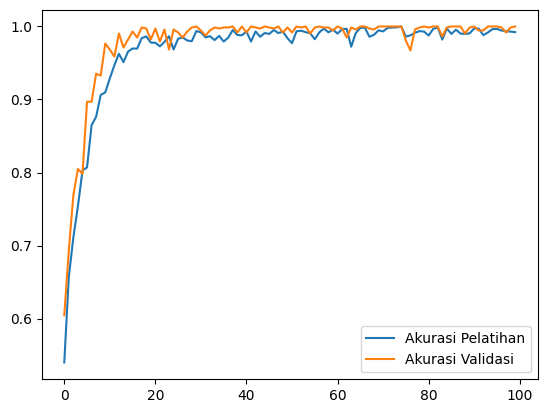

In [24]:
# Menampilkan hasil pelatihan
plt.plot(history.history['accuracy'], label='Akurasi Pelatihan')
plt.plot(history.history['val_accuracy'], label='Akurasi Validasi')
plt.legend()
plt.savefig('acc1.png')
plt.show()



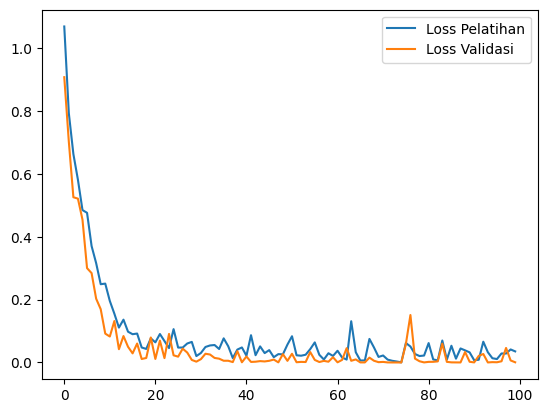

In [25]:
# Menampilkan hasil pelatihan
plt.plot(history.history['loss'], label='Loss Pelatihan')
plt.plot(history.history['val_loss'], label='Loss Validasi')
plt.legend()
plt.savefig('loss1.png')
plt.show()


46/46 ━━━━━━━━━━━━━━━━━━━━ 9s 78ms/step


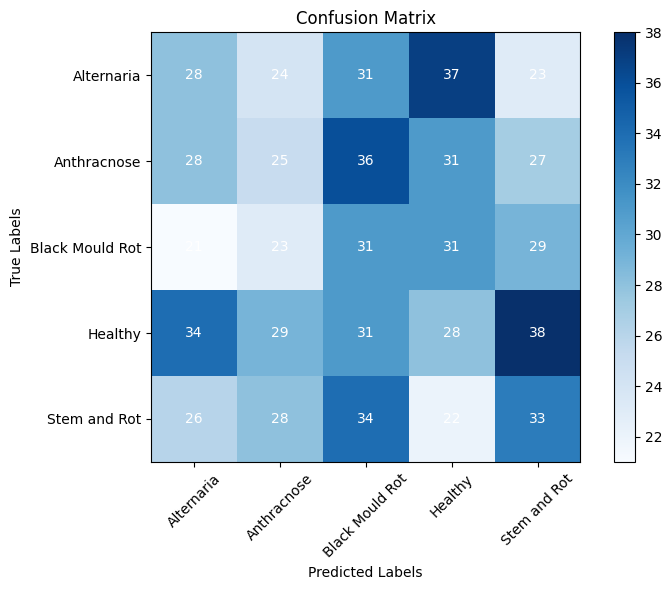

In [26]:
# Evaluasi
predictions = model.predict(validation_dataset)
predicted_labels = np.argmax(predictions, axis=1)

true_labels = []
for images, labels in validation_dataset:
    true_labels.extend(np.argmax(labels.numpy(), axis=1))

conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Menampilkan dan menyimpan confusion matrix sebagai gambar
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, cmap=plt.cm.Blues)
plt.colorbar()
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.xticks(ticks=np.arange(len(class_names)), labels=class_names, rotation=45)
plt.yticks(ticks=np.arange(len(class_names)), labels=class_names)
plt.tight_layout()

thresh = conf_matrix.max() / 2.
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if conf_matrix[i, j] > thresh else "black")

# Simpan gambar confusion matrix
plt.savefig('confusion_matrix2.png')

plt.show()



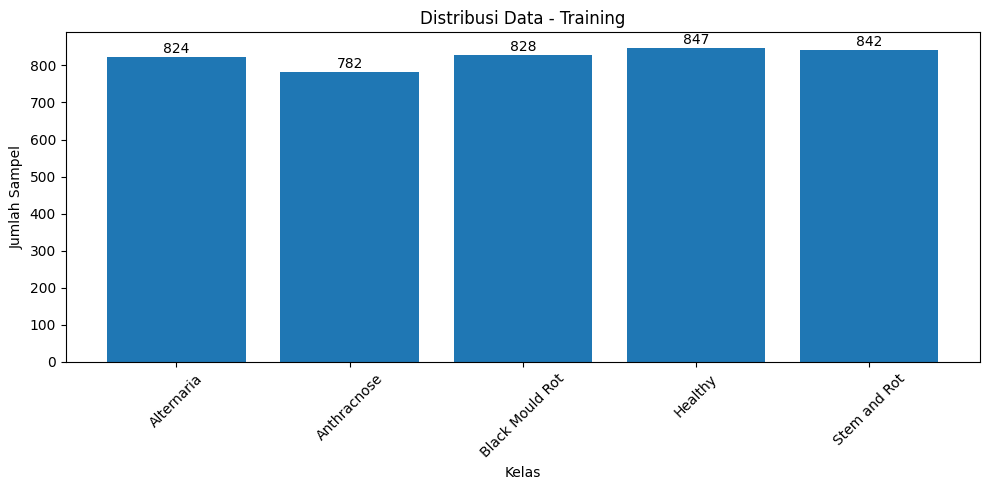

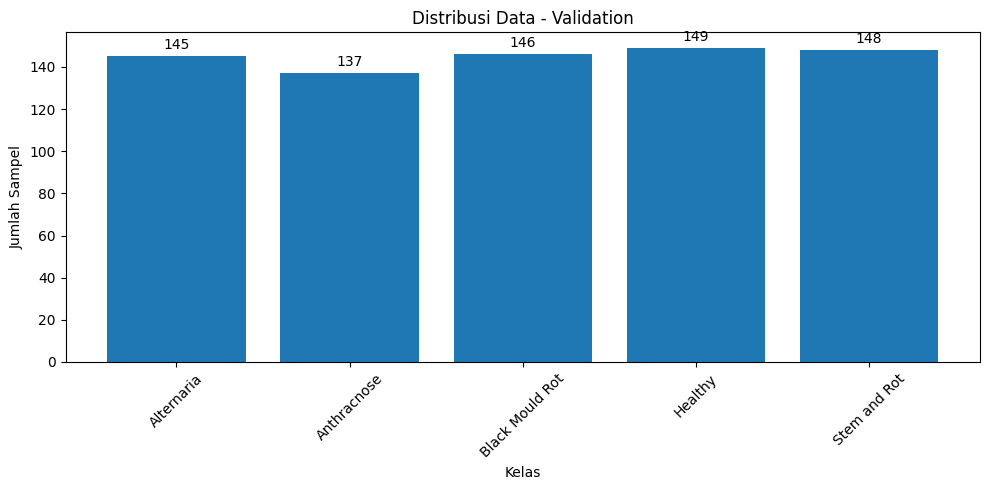

In [27]:
# Menampilkan distribusi data
def plot_data_distribution(generator, subset):
    class_counts = generator.classes
    class_counts = np.bincount(class_counts)
    
    plt.figure(figsize=(10, 5))
    plt.bar(class_names, class_counts)
    plt.title(f'Distribusi Data - {subset}')
    plt.xlabel('Kelas')
    plt.ylabel('Jumlah Sampel')
    plt.xticks(rotation=45)
    
    # Menambahkan keterangan
    for i, count in enumerate(class_counts):
        plt.text(i, count + 2, str(count), ha='center', va='bottom')
    
    plt.tight_layout()
    plt.savefig(f'data_distribution_{subset.lower()}.png')
    plt.show()

# Plot distribusi data pelatihan dan validasi
plot_data_distribution(train_generator, 'Training')
plot_data_distribution(validation_generator, 'Validation')

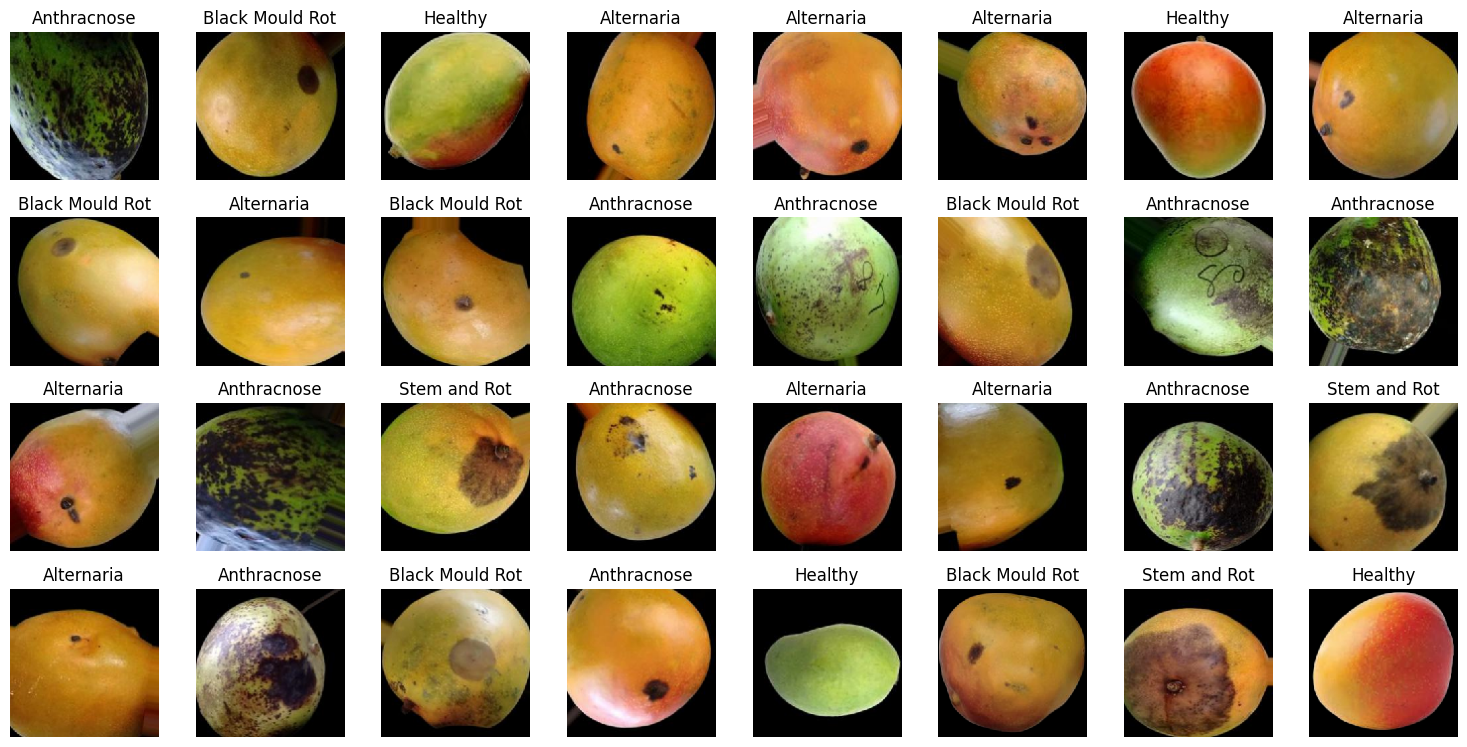

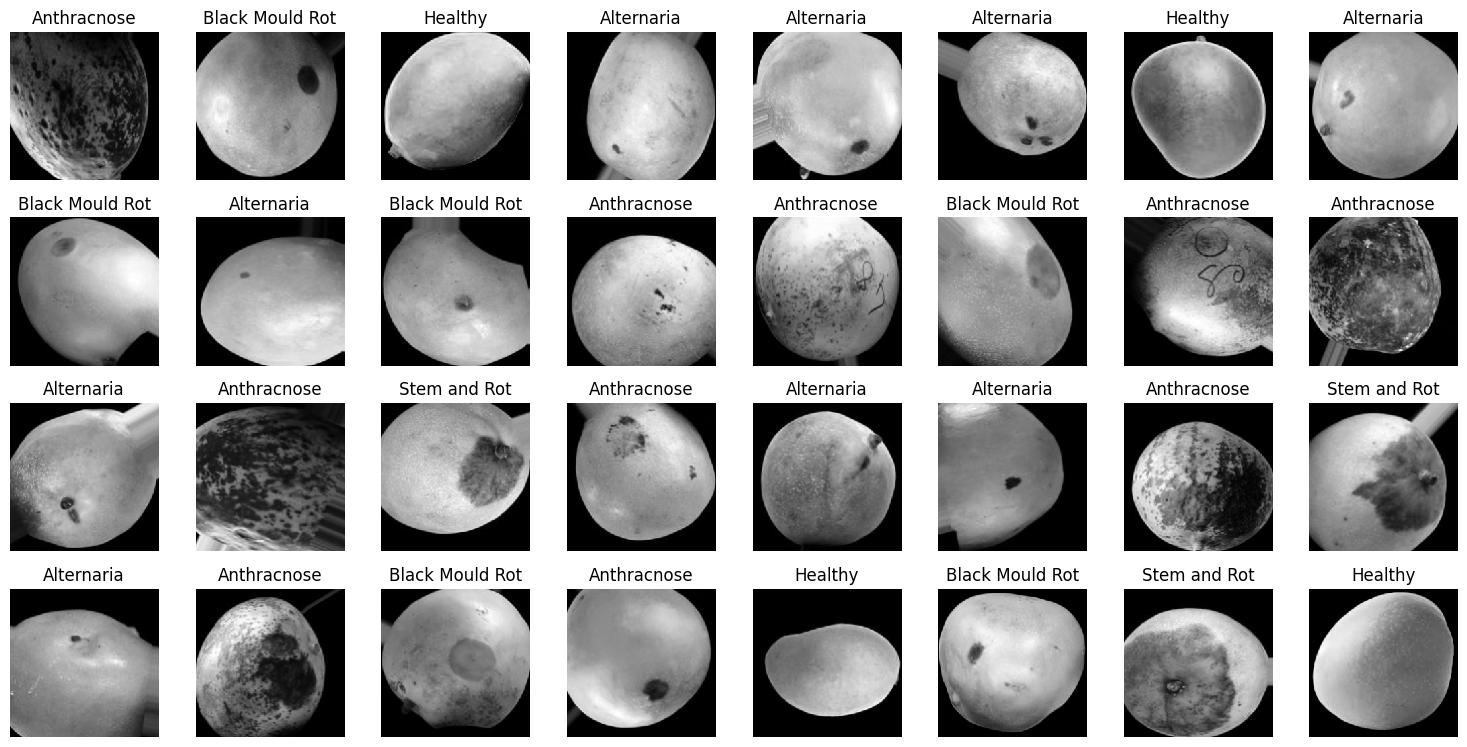

In [23]:
# Menampilkan beberapa gambar dari dataset setelah resize dan normalisasi
def plot_sample_images(generator, num_images):
    images, labels = next(generator)
    plt.figure(figsize=(15, 15))
    for i in range(num_images):
        ax = plt.subplot(8, 8, i + 1)
        plt.imshow(images[i])
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis("off")
    plt.tight_layout()
    plt.savefig('sample_images_color.png')
    plt.show()

    # Menampilkan gambar dalam grayscale
    plt.figure(figsize=(15, 15))
    for i in range(num_images):
        ax = plt.subplot(8, 8, i + 1)
        gray_image = tf.image.rgb_to_grayscale(images[i])
        plt.imshow(tf.squeeze(gray_image), cmap='gray')
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis("off")
    plt.tight_layout()
    plt.savefig('sample_images_gray.png')
    plt.show()

plot_sample_images(train_generator, 32)

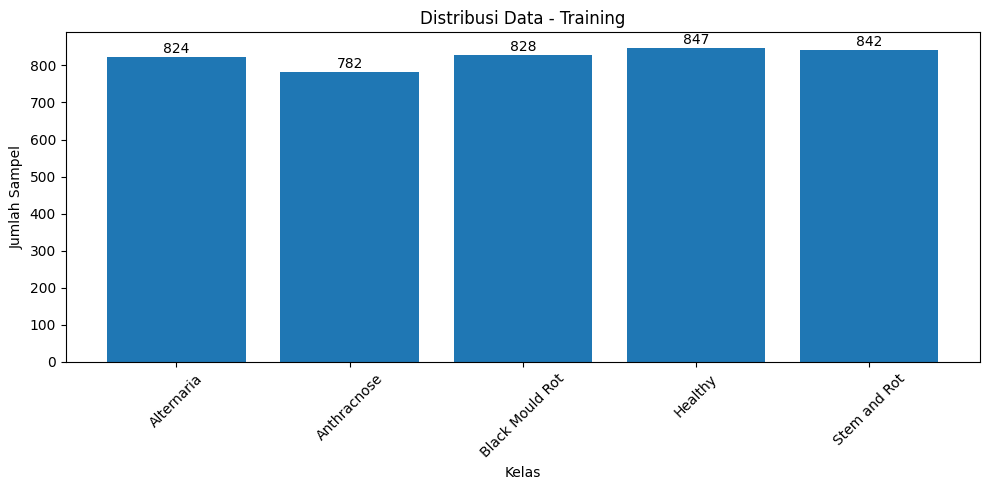

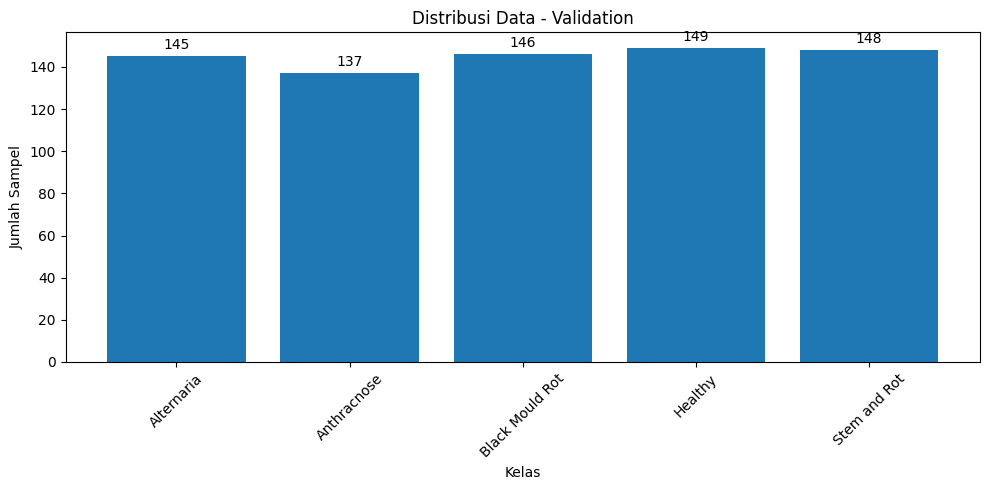

In [21]:
# Menampilkan distribusi data
def plot_data_distribution(generator, subset):
    class_counts = generator.classes
    class_counts = np.bincount(class_counts)
    
    plt.figure(figsize=(10, 5))
    plt.bar(class_names, class_counts)
    plt.title(f'Distribusi Data - {subset}')
    plt.xlabel('Kelas')
    plt.ylabel('Jumlah Sampel')
    plt.xticks(rotation=45)
    
    # Menambahkan keterangan
    for i, count in enumerate(class_counts):
        plt.text(i, count + 2, str(count), ha='center', va='bottom')
    
    plt.tight_layout()
    plt.savefig(f'data_distribution_{subset.lower()}.png')
    plt.show()

# Plot distribusi data pelatihan dan validasi
plot_data_distribution(train_generator, 'Training')
plot_data_distribution(validation_generator, 'Validation')

In [28]:
model.save('save_model_16x100.h5')